# Лабораторная работа 5
Тема: Построение нейронной сети для классификации изображений с помощью Keras (TensorFlow).


Датасет: Fashion-MNIST (10 классов). Можно легко переключиться на классический MNIST (цифры).
Fashion-MNIST — это датасет, содержащий 70,000 изображений одежды в градациях серого (28x28 пикселей), разделенных на 10 классов (например, футболки, брюки, платья). Датасет включает 60,000 тренировочных изображений и 10,000 тестовых, каждое с меткой, указывающей на один из 10 классов

https://grok.com/share/c2hhcmQtMg%3D%3D_06168270-e878-47ae-8ab1-37048fd754b7

## 1. Импорт библиотек

In [1]:
%pip install numpy matplotlib tensorflow scikit-learn seaborn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# фиксируем сид для воспроизводимости
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vladk\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
Note: you may need to restart the kernel to use updated packages.
TensorFlow version: 2.20.0


## 2. Загрузка и предобработка данных
Используем Fashion-MNIST: 28x28 grayscale изображения, 10 классов.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Масштабирование пикселей в [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Для сверточных слоёв требуется 4D-тензор (вектор (башенка) кубиков): (batch, height, width, channels)
x_train = np.expand_dims(x_train, -1)  # shape (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
Number of classes: 10


Покажем несколько примеров изображений.

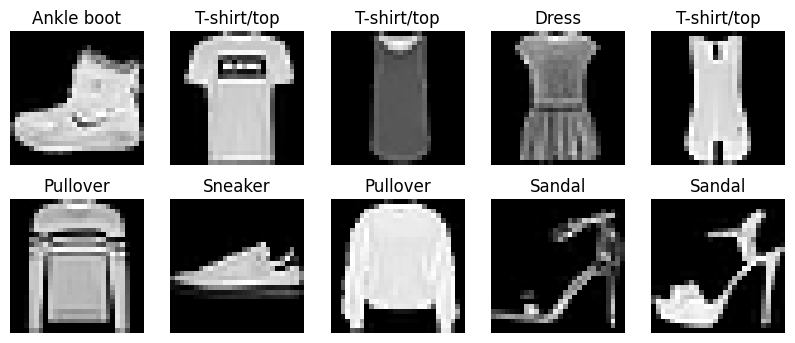

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()


## 3. Функция для построения и компиляции модели
Сделаем функцию build_model(dropout_rate=...) чтобы можно было легко включать регуляризацию.

In [4]:
def build_cnn_model(input_shape=(28,28,1), num_classes=10, dropout_rate=0.0):
    """Построить и скомпилировать простую CNN модель.
    dropout_rate: если > 0, добавляет Dropout слои для регуляризации.
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Создадим и посмотрим сводку модели
model = build_cnn_model(dropout_rate=0.0)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

1. Input(shape=(28, 28, 1))

Принимает одно изображение 28×28×1 (grayscale).
None в (None, 28, 28, 1) — размер батча (может быть любым).


2. Conv2D(32, 3, padding='same', activation='relu')
Что делает:

Применяет 32 фильтра 3×3 к входу.
Каждый фильтр "скользит" по изображению, вычисляя свёртку.

Математика свёртки:
textoutput[i,j] = sum_{dx,dy} input[i+dx, j+dy] * kernel[dx, dy] + bias
padding='same' → добавляет нули по краям → выходной размер = входной (28×28).
activation='relu' → f(x) = max(0, x) → убирает отрицательные значения.

Зачем 32 фильтра?
Каждый фильтр учится находить свой тип признака: края, углы, текстуры.


3. Второй Conv2D(32, 3, ...)

Принимает 32 карты признаков.
Создаёт новые комбинации признаков.
Например: "горизонтальный край + вертикальный угол" → "угол рубашки".


4. MaxPooling2D(2)

Берёт максимум в окне 2×2.
Уменьшает размер в 2 раза: 28×28 → 14×14.
Снижает вычисления, увеличивает обобщение.


5. Dropout(0.4)

Случайно обнуляет 40% нейронов на каждом шаге обучения.
Во время теста — все нейроны активны, но умножаются на 1/(1-0.4) = 1.67.


Зачем?
Предотвращает переобучение — модель не запоминает шум.


6. Блок 2: Conv2D(64, ...) × 2 + MaxPooling + Dropout

64 фильтра → более сложные признаки (формы, узоры).
После пулинга: 7×7×64.


7. Flatten()

Преобразует (7, 7, 64) → (3136,)
7 × 7 × 64 = 3136


8. Dense(256, activation='relu')

Полносвязный слой.
Каждый из 3136 входов соединён с каждым из 256 нейронов.
Учится комбинировать признаки для классификации.


9. Dropout(0.4) — снова

Перед финальным слоем — критично, т.к. здесь легко переобучиться.


10. Dense(10, activation='softmax')

10 нейронов → по одному на класс.
softmax → превращает логиты в вероятности:
textp_i = exp(z_i) / sum(exp(z_j))

Сумма вероятностей = 1.

## 4. Обучение модели (без Dropout) — базовый запуск

In [ ]:
EPOCHS = 12
BATCH_SIZE = 128

model_baseline = build_cnn_model(dropout_rate=0.0)

history_baseline = model_baseline.fit(
    x_train, y_train,
    epochs=EPOCHS,#30 проходов
    batch_size=BATCH_SIZE,#128 изображений
    validation_split=0.1,#10% = 6000 изображений
    verbose=2#Вывод по эпохам
)


Epoch 1/12
422/422 - 10s - 23ms/step - accuracy: 0.8200 - loss: 0.5021 - val_accuracy: 0.8768 - val_loss: 0.3457
Epoch 2/12
422/422 - 8s - 20ms/step - accuracy: 0.8850 - loss: 0.3208 - val_accuracy: 0.8955 - val_loss: 0.2940
Epoch 3/12
422/422 - 8s - 20ms/step - accuracy: 0.9004 - loss: 0.2739 - val_accuracy: 0.8998 - val_loss: 0.2688
Epoch 4/12
422/422 - 8s - 20ms/step - accuracy: 0.9116 - loss: 0.2425 - val_accuracy: 0.9093 - val_loss: 0.2499
Epoch 5/12
422/422 - 8s - 19ms/step - accuracy: 0.9208 - loss: 0.2177 - val_accuracy: 0.9110 - val_loss: 0.2465
Epoch 6/12
422/422 - 8s - 19ms/step - accuracy: 0.9283 - loss: 0.1970 - val_accuracy: 0.9100 - val_loss: 0.2459
Epoch 7/12
422/422 - 8s - 19ms/step - accuracy: 0.9366 - loss: 0.1773 - val_accuracy: 0.9115 - val_loss: 0.2406
Epoch 8/12
422/422 - 8s - 19ms/step - accuracy: 0.9434 - loss: 0.1588 - val_accuracy: 0.9113 - val_loss: 0.2441
Epoch 9/12
422/422 - 8s - 19ms/step - accuracy: 0.9505 - loss: 0.1408 - val_accuracy: 0.9137 - val_loss

## 5. Визуализация loss и accuracy (train / val)

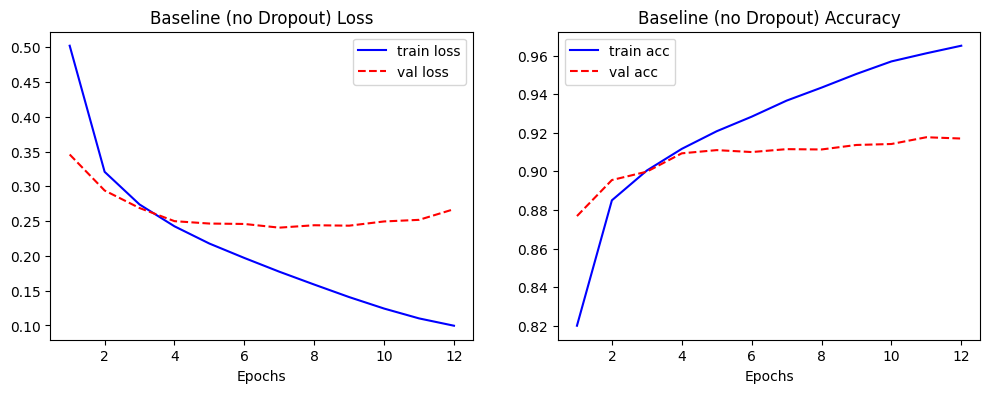

In [6]:
def plot_history(history, title_prefix=''):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], 'b-', label='train loss')
    plt.plot(epochs, hist['val_loss'], 'r--', label='val loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], 'b-', label='train acc')
    plt.plot(epochs, hist['val_accuracy'], 'r--', label='val acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

plot_history(history_baseline, title_prefix='Baseline (no Dropout)')


## 6. Оценка на тестовой выборке и метрики качества

Baseline test loss: 0.2840, test accuracy: 0.9111
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.84      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.81      0.90      0.85      1000
       Dress       0.91      0.92      0.91      1000
        Coat       0.87      0.83      0.85      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.76      0.76      0.76      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



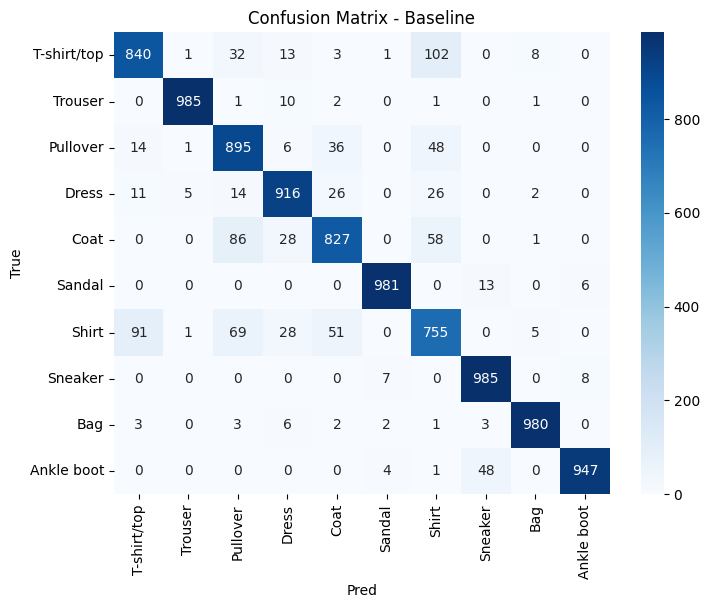

In [7]:
test_loss, test_acc = model_baseline.evaluate(x_test, y_test, verbose=0)
print(f"Baseline test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}")

# Предсказания для построения отчёта
y_pred_probs = model_baseline.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True')
plt.xlabel('Pred')
plt.title('Confusion Matrix - Baseline')
plt.show()


Если на графиках видно сильное расхождение между train и val (или test) — значит модель переобучается. Применим Dropout и повторим обучение.

## 7. Обучение с Dropout (регуляризация)

Epoch 1/12
422/422 - 10s - 25ms/step - accuracy: 0.7824 - loss: 0.6019 - val_accuracy: 0.8640 - val_loss: 0.3667
Epoch 2/12
422/422 - 9s - 21ms/step - accuracy: 0.8608 - loss: 0.3892 - val_accuracy: 0.8815 - val_loss: 0.3133
Epoch 3/12
422/422 - 9s - 21ms/step - accuracy: 0.8771 - loss: 0.3389 - val_accuracy: 0.8953 - val_loss: 0.2815
Epoch 4/12
422/422 - 9s - 21ms/step - accuracy: 0.8879 - loss: 0.3078 - val_accuracy: 0.9013 - val_loss: 0.2640
Epoch 5/12
422/422 - 9s - 21ms/step - accuracy: 0.8964 - loss: 0.2852 - val_accuracy: 0.9062 - val_loss: 0.2482
Epoch 6/12
422/422 - 9s - 22ms/step - accuracy: 0.9025 - loss: 0.2678 - val_accuracy: 0.9127 - val_loss: 0.2373
Epoch 7/12
422/422 - 9s - 21ms/step - accuracy: 0.9063 - loss: 0.2535 - val_accuracy: 0.9132 - val_loss: 0.2309
Epoch 8/12
422/422 - 9s - 21ms/step - accuracy: 0.9126 - loss: 0.2404 - val_accuracy: 0.9152 - val_loss: 0.2249
Epoch 9/12
422/422 - 10s - 23ms/step - accuracy: 0.9144 - loss: 0.2309 - val_accuracy: 0.9160 - val_los

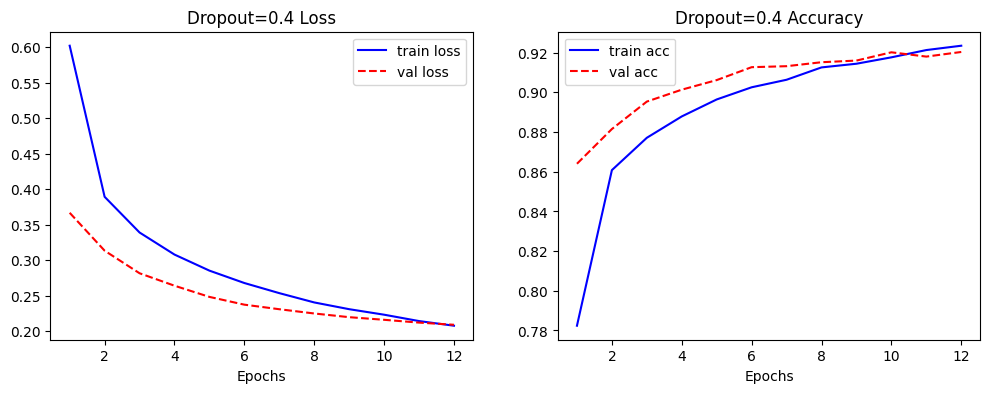

Dropout model test loss: 0.2210, test accuracy: 0.9185


In [ ]:
dropout_rate = 0.4 #на каждом шаге обучения 40% нейронов будут случайным образом "выключены" (их выход = 0) 
#Эквивалентно обучению тысяч моделей Не даёт запомнить шум Каждый нейрон учится самостоятельно работать
model_dropout = build_cnn_model(dropout_rate=dropout_rate)

history_dropout = model_dropout.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2
)
plot_history(history_dropout, title_prefix=f'Dropout={dropout_rate}')

test_loss_d, test_acc_d = model_dropout.evaluate(x_test, y_test, verbose=0)
print(f"Dropout model test loss: {test_loss_d:.4f}, test accuracy: {test_acc_d:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification report (Dropout):
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.90      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.86      0.88      0.87      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.81      0.70      0.75      1000
     Sneaker       0.96      0.97      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



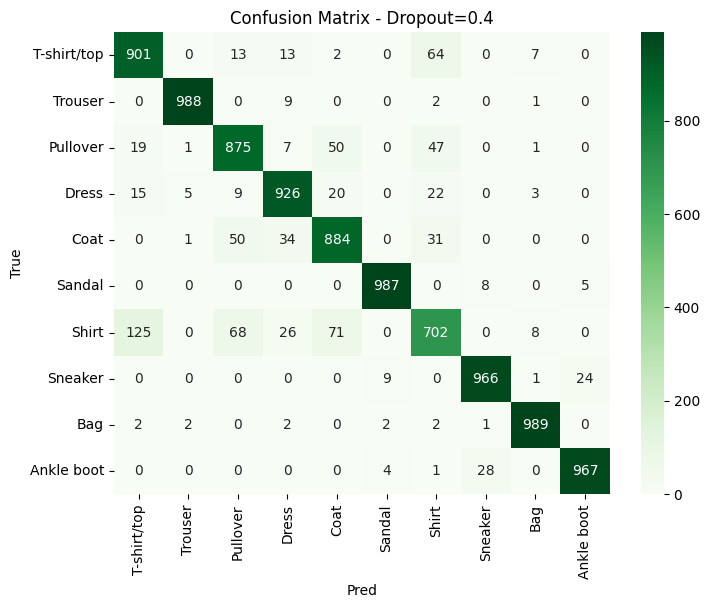

In [9]:
# Отчёт и матрица для модели с Dropout
y_pred_probs_d = model_dropout.predict(x_test)
y_pred_d = np.argmax(y_pred_probs_d, axis=1)
print('\nClassification report (Dropout):')
print(classification_report(y_test, y_pred_d, target_names=class_names))
cm_d = confusion_matrix(y_test, y_pred_d)
plt.figure(figsize=(8,6))
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True')
plt.xlabel('Pred')
plt.title(f'Confusion Matrix - Dropout={dropout_rate}')
plt.show()


## 8. Сравнение кривых обучения (Baseline vs Dropout)
Отобразим loss/accuracy обеих моделей на одной фигуре для удобного сравнения.

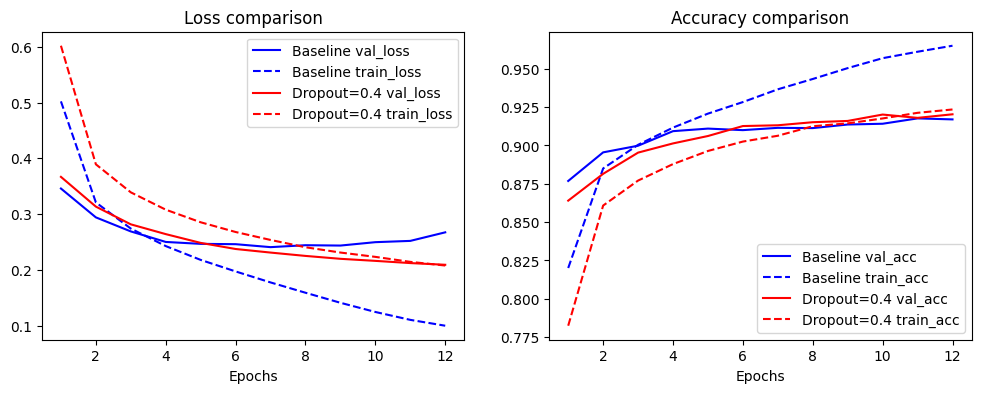

In [10]:
def compare_histories(hist1, label1, hist2, label2):
    e1 = range(1, len(hist1.history['loss'])+1)
    e2 = range(1, len(hist2.history['loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(e1, hist1.history['val_loss'], 'b-', label=f'{label1} val_loss')
    plt.plot(e1, hist1.history['loss'], 'b--', label=f'{label1} train_loss')
    plt.plot(e2, hist2.history['val_loss'], 'r-', label=f'{label2} val_loss')
    plt.plot(e2, hist2.history['loss'], 'r--', label=f'{label2} train_loss')
    plt.title('Loss comparison')
    plt.legend()
    plt.xlabel('Epochs')
    
    plt.subplot(1,2,2)
    plt.plot(e1, hist1.history['val_accuracy'], 'b-', label=f'{label1} val_acc')
    plt.plot(e1, hist1.history['accuracy'], 'b--', label=f'{label1} train_acc')
    plt.plot(e2, hist2.history['val_accuracy'], 'r-', label=f'{label2} val_acc')
    plt.plot(e2, hist2.history['accuracy'], 'r--', label=f'{label2} train_acc')
    plt.title('Accuracy comparison')
    plt.legend()
    plt.xlabel('Epochs')
    plt.show()

compare_histories(history_baseline, 'Baseline', history_dropout, f'Dropout={dropout_rate}')


## 9. Эксперименты с архитектурой и гиперпараметрами
Пример: увеличить число фильтров, добавить ещё слой Conv, или изменить оптимизатор.
Ниже — пример более глубокой модели.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,634 (3.32 MB)

 Trainable params: 870,634 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
422/422 - 24s - 58ms/step - accuracy: 0.8112 - loss: 0.5196 - val_accuracy: 0.8827 - val_loss: 0.3046
Epoch 2/8
422/422 - 22s - 52ms/step - accuracy: 0.8852 - loss: 0.3157 - val_accuracy: 0.9063 - val_loss: 0.2519
Epoch 3/8
422/422 - 22s - 53ms/step - accuracy: 0.9006 - loss: 0.2679 - val_accuracy: 0.9120 - val_loss: 0.2313
Epoch 4/8
422/422 - 20s - 46ms/step - accuracy: 0.9112 - loss: 0.2403 - val_accuracy: 0.9203 - val_loss: 0.2163
Epoch 5/8
422/422 - 22s - 53ms/step - accuracy: 0.9208 - loss: 0.2157 - val_accuracy: 0.9232 - val_loss: 0.2086
Epoch 6/8
422/422 - 21s - 49ms/step - accuracy: 0.9252 - loss: 0.1994 - val_accuracy: 0.9267 - val_loss: 0.1992
Epoch 7/8
422/422 - 23s - 55ms/step - accuracy: 0.9301 - loss: 0.1861 - val_accuracy: 0.9280 - val_loss: 0.1962
Epoch 8/8
422/422 - 23s - 53ms/step - accuracy: 0.9360 - loss: 0.1732 - val_accuracy: 0.9280 - val_loss: 0.1979


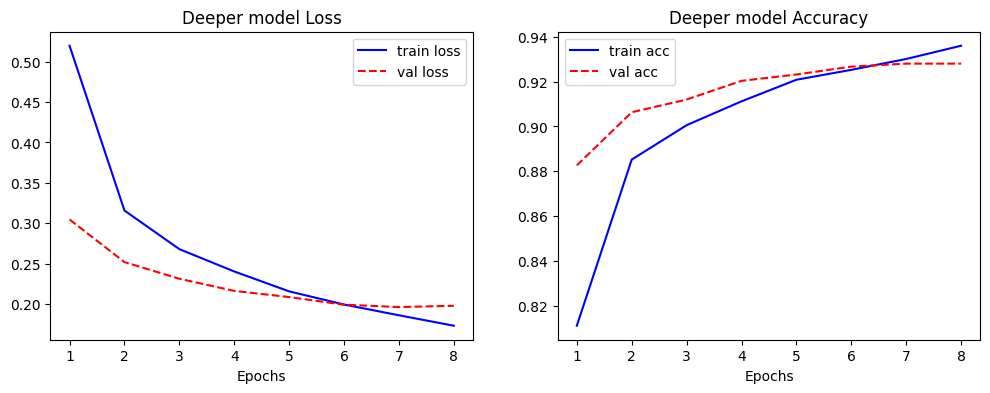

Deeper model test loss: 0.2156, test accuracy: 0.9231


In [ ]:
def build_deeper_model(input_shape=(28,28,1), num_classes=10, dropout_rate=0.4):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding=  'same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_deep = build_deeper_model()
model_deep.summary()

# Быстрое обучение (меньше эпох для демонстрации)
history_deep = model_deep.fit(x_train, y_train, epochs=8, batch_size=128, validation_split=0.1, verbose=2)
plot_history(history_deep, title_prefix='Deeper model')
test_loss_deep, test_acc_deep = model_deep.evaluate(x_test, y_test, verbose=0)
print(f"Deeper model test loss: {test_loss_deep:.4f}, test accuracy: {test_acc_deep:.4f}")


## 10. Выводы и рекомендации
- Масштабирование входных признаков (пикселей) в [0,1] существенно упрощает обучение.
- Для изображений хорошо подходят сверточные сети (Conv2D + Pooling).
- Активация ReLU обычно используется в сверточных/плотных скрытых слоях; softmax на выходе для многоклассовой классификации.
- Оптимизатор Adam — хороший выбор по умолчанию; функция потерь для целых меток — sparse_categorical_crossentropy.
- Если наблюдается переобучение (train >> val), используйте регуляризацию: Dropout, L2, уменьшение сложности модели, data augmentation.
- Для дальнейшей работы: добавить раннюю остановку (EarlyStopping), аугментацию изображений, k-fold валидацию, подбор гиперпараметров (GridSearch/RandomSearch) либо Bayesian optimization.

Вы можете запустить этот ноутбук в Colab или локально. Если хотите, могу:
- Переключить датасет на MNIST (цифры).
- Добавить практическую аугментацию изображений и показать эффект.
- Сохранить и показать веса лучшей модели (ModelCheckpoint).


### 1. Что такое архитектура нейронной сети? От чего зависит выбор архитектуры?

#### Что такое архитектура нейронной сети?
Архитектура нейронной сети — это структура, определяющая, как организованы слои нейронов, их типы, связи между ними и порядок обработки данных. Она описывает:
- Количество и типы слоев (например, сверточные, полносвязные, пулинг, dropout).
- Размеры слоев (число нейронов или фильтров).
- Функции активации (например, ReLU, softmax).
- Порядок соединения слоев (например, последовательный или с пропусками, как в ResNet).

В предоставленном ноутбуке архитектура модели (`build_deeper_model`) включает:
- Входной слой (`InputLayer`): принимает изображения 28x28x1.
- Сверточные слои (`Conv2D`): извлекают признаки из изображений.
- Слои пулинга (`MaxPooling2D`): уменьшают размерность данных.
- Слои Dropout: предотвращают переобучение.
- Слой Flatten: преобразует данные в одномерный вектор.
- Полносвязные слои (`Dense`): выполняют классификацию.

#### От чего зависит выбор архитектуры?
Выбор архитектуры зависит от следующих факторов:
1. **Тип задачи**:
   - Классификация изображений (как в Fashion-MNIST): обычно используют сверточные нейронные сети (CNN), как в ноутбуке, из-за их способности эффективно обрабатывать пространственные данные.
   - Обработка текста: рекуррентные сети (RNN) или трансформеры.
   - Регрессия: могут использоваться полносвязные сети или CNN в зависимости от данных.
2. **Характеристики данных**:
   - Размер входных данных: для изображений 28x28 (Fashion-MNIST) достаточно компактной CNN. Для больших изображений (например, 224x224 в ImageNet) нужны более глубокие сети, такие как VGG или ResNet.
   - Тип данных: изображения требуют сверточных слоев, временные ряды — RNN или LSTM.
3. **Вычислительные ресурсы**:
   - Ограниченные ресурсы (например, CPU): выбирают более простые архитектуры, как в таблице (два `Conv2D` слоя, 421,642 параметра).
   - Мощные GPU/TPU: можно использовать глубокие модели с миллионами параметров.
4. **Производительность и обобщение**:
   - Простые архитектуры минимизируют переобучение на небольших датасетах (Fashion-MNIST — 60,000 изображений).
   - Сложные архитектуры (например, с четырьмя `Conv2D`, как в `build_deeper_model`) лучше подходят для сложных задач, но требуют регуляризации (например, Dropout).
5. **Состояние области (state-of-the-art)**:
   - Используют проверенные архитектуры (например, LeNet для простых задач, как Fashion-MNIST, или ResNet для сложных).
   - В ноутбуке выбрана CNN с несколькими сверточными слоями, что является стандартным подходом для классификации изображений.
6. **Цель эксперимента**:
   - Для обучения или демонстрации (как в ноутбуке) выбирают простые архитектуры, которые легко понять и быстро обучаются.
   - Для высокой точности могут требоваться сложные модели или ансамбли.

**В ноутбуке**: Архитектура выбрана как компромисс между простотой и эффективностью для Fashion-MNIST. Четыре сверточных слоя и два полносвязных слоя обеспечивают хорошую производительность (92.31% точности), а Dropout (0.4) помогает избежать переобучения.

---

### 2. Расскажите про сверточные слои

#### Что такое сверточные слои (`Conv2D`)?
Сверточные слои (`Conv2D` в Keras) — это ключевой компонент сверточных нейронных сетей (CNN), используемый для обработки изображений. Они применяют операцию свертки, которая извлекает локальные признаки (например, края, углы, текстуры) из входных данных, сохраняя пространственную структуру.

#### Как работают сверточные слои?
- **Ядро (фильтр)**: Небольшая матрица (например, 3x3), которая "скользит" по входному изображению, вычисляя скалярное произведение для создания карты признаков.
- **Шаг (stride)**: Расстояние, на которое ядро смещается на каждом шаге (обычно 1).
- **Паддинг (padding)**: Добавление нулей по краям изображения, чтобы сохранить его размер (`padding='same'`) или уменьшить (`padding='valid'`).
- **Число фильтров**: Каждый фильтр создает одну карту признаков. Например, 32 фильтра создают 32 карты, каждая из которых выделяет разные аспекты изображения.
- **Активация**: После свертки применяется функция активации (обычно ReLU), чтобы добавить нелинейность.

#### Пример из ноутбука
В модели `build_deeper_model`:
- Первый слой `Conv2D(32, 3, activation='relu', padding='same')`:
  - 32 фильтра размером 3x3.
  - `padding='same'`: сохраняет размер входа (28x28).
  - Выход: `(None, 28, 28, 32)` (32 карты признаков).
- Второй слой `Conv2D(64, 3, activation='relu', padding='same')`:
  - 64 фильтра, принимает 32 канала от предыдущего слоя.
  - Выход: `(None, 14, 14, 64)` (после пулинга).

#### Зачем нужны сверточные слои?
- **Извлечение признаков**: Они улавливают локальные шаблоны (например, края одежды в Fashion-MNIST), которые затем комбинируются в более сложные признаки (например, формы или текстуры).
- **Снижение параметров**: В отличие от полносвязных слоев, сверточные слои используют общие веса (фильтры), что уменьшает количество параметров и вычислительную сложность.
- **Пространственная инвариантность**: Фильтры работают независимо от положения признака на изображении, что делает CNN устойчивыми к сдвигам или небольшим изменениям.

#### Почему в ноутбуке?
Fashion-MNIST содержит изображения, где важно учитывать пространственные отношения (например, форма футболки). Сверточные слои эффективно извлекают такие признаки, что делает их идеальными для задачи.

---

### 3. Что такое функция активации и какие функции активации бывают?

#### Что такое функция активации?
Функция активации — это математическая функция, применяемая к выходу нейрона или слоя, чтобы ввести нелинейность в модель. Без нелинейности нейронные сети не могли бы моделировать сложные зависимости в данных, так как линейные преобразования (например, умножение на веса) ограничены.

#### Зачем нужна?
- **Нелинейность**: Позволяет модели обучаться сложным шаблонам, например, распознавать разные типы одежды в Fashion-MNIST.
- **Ограничение значений**: Некоторые функции активации (например, sigmoid) ограничивают выход в определенный диапазон, что полезно для интерпретации (например, вероятности).

#### Основные функции активации
1. **ReLU (Rectified Linear Unit)**:
   - Формула: `f(x) = max(0, x)`.
   - Диапазон: `[0, +∞)`.
   - Преимущества: Простая, ускоряет обучение, решает проблему исчезающего градиента.
   - Недостатки: "Умирающие нейроны" (если входы всегда отрицательные, нейрон "выключается").
   - **В ноутбуке**: Используется в сверточных и полносвязных слоях (`Conv2D`, `Dense`), так как подходит для скрытых слоев и помогает модели обучаться сложным признакам.
2. **Softmax**:
   - Формула: Преобразует вектор в вероятности, где сумма всех выходов = 1: `f(x_i) = exp(x_i) / sum(exp(x_j))`.
   - Диапазон: `[0, 1]`.
   - Преимущества: Идеальна для многоклассовой классификации, так как выдает вероятности для каждого класса.
   - **В ноутбуке**: Используется в выходном слое (`Dense(10, activation='softmax')`), чтобы предсказать вероятности для 10 классов Fashion-MNIST.
3. **Sigmoid**:
   - Формула: `f(x) = 1 / (1 + exp(-x))`.
   - Диапазон: `(0, 1)`.
   - Преимущества: Подходит для бинарной классификации.
   - Недостатки: Проблема исчезающего градиента при больших или малых входах.
   - Использование: Не используется в ноутбуке, так как задача многоклассовая.
4. **Tanh (Hyperbolic Tangent)**:
   - Формула: `f(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))`.
   - Диапазон: `(-1, 1)`.
   - Преимущества: Центрирует данные (нулевое среднее), что может улучшить обучение.
   - Недостатки: Проблема исчезающего градиента.
   - Использование: Не применяется в ноутбуке.
5. **Leaky ReLU**:
   - Формула: `f(x) = x if x > 0, else αx` (где `α` — малое число, например, 0.01).
   - Преимущества: Решает проблему "умирающих нейронов" ReLU.
   - Использование: Не применяется в ноутбуке, но может быть альтернативой ReLU.
6. **Linear**:
   - Формула: `f(x) = x`.
   - Диапазон: `(-∞, +∞)`.
   - Преимущества: Используется в регрессии, где выход не ограничен.
   - Недостатки: Не добавляет нелинейности.
   - Использование: Не применяется в ноутбуке.

#### Почему в ноутбуке выбраны ReLU и Softmax?
- **ReLU**: Используется в скрытых слоях, так как она проста, эффективна и хорошо работает для извлечения признаков из изображений.
- **Softmax**: Подходит для выходного слоя, так как Fashion-MNIST — это задача многоклассовой классификации (10 классов), и softmax выдает вероятности для каждого класса.

---

### 4. Какие оптимизаторы, функции потерь и метрики используются для компиляции модели и чем руководствоваться при их подборе?

#### Оптимизаторы
Оптимизатор — это алгоритм, который минимизирует функцию потерь, обновляя веса модели на основе градиентов.

1. **Adam (Adaptive Moment Estimation)**:
   - **Описание**: Комбинирует моменты первого и второго порядка (среднее и дисперсию градиентов), адаптируя шаг обучения для каждого параметра.
   - **Преимущества**: Быстрая сходимость, устойчивость, подходит для большинства задач.
   - **В ноутбуке**: Используется (`Adam(learning_rate=1e-3)`), так как это надежный выбор по умолчанию для CNN.
2. **SGD (Stochastic Gradient Descent)**:
   - **Описание**: Простой градиентный спуск с фиксированным шагом обучения, иногда с моментом.
   - **Преимущества**: Может дать лучшее обобщение в некоторых случаях.
   - **Недостатки**: Медленнее, требует тщательной настройки шага обучения.
3. **RMSprop**:
   - **Описание**: Адаптирует шаг обучения на основе экспоненциального среднего квадратов градиентов.
   - **Преимущества**: Хорошо работает для нестационарных данных (например, RNN).
4. **Adagrad**, **Adadelta**: Другие адаптивные оптимизаторы, реже используемые.

**Подбор оптимизатора**:
- **Тип задачи**: Adam подходит для большинства задач, включая классификацию изображений (Fashion-MNIST). SGD может быть полезен для тонкой настройки.
- **Размер датасета**: Для больших датасетов (как Fashion-MNIST) Adam эффективен из-за адаптивности.
- **Скорость обучения**: Adam менее чувствителен к выбору шага обучения (`1e-3` в ноутбуке — стандартное значение).
- **Ресурсы**: Adam быстрее сходится, что важно для ограниченных вычислительных ресурсов.

#### Функции потерь
Функция потерь измеряет ошибку между предсказаниями модели и истинными метками.

1. **Sparse Categorical Crossentropy**:
   - **Описание**: Используется для многоклассовой классификации с целочисленными метками.
   - **В ноутбуке**: Применяется (`loss='sparse_categorical_crossentropy'`), так как Fashion-MNIST имеет 10 классов с целочисленными метками (0–9).
2. **Categorical Crossentropy**:
   - Для многоклассовой классификации с one-hot кодированием меток.
   - Не используется в ноутбуке, так как метки Fashion-MNIST — целые числа.
3. **Binary Crossentropy**:
   - Для бинарной классификации.
   - Не подходит для Fashion-MNIST (10 классов).
4. **Mean Squared Error (MSE)**:
   - Для регрессии, когда предсказываются непрерывные значения.
   - Не используется в ноутбуке.

**Подбор функции потерь**:
- **Тип задачи**: Для классификации — кросс-энтропия (sparse для целочисленных меток, categorical для one-hot). Для регрессии — MSE или MAE.
- **Формат меток**: В Fashion-MNIST метки целочисленные (0–9), поэтому выбрана `sparse_categorical_crossentropy`.
- **Цель**: Минимизировать ошибку классификации, обеспечивая, чтобы модель училась различать классы.

#### Метрики
Метрики оценивают производительность модели во время обучения и тестирования.

1. **Accuracy**:
   - **Описание**: Доля правильно классифицированных примеров.
   - **В ноутбуке**: Используется (`metrics=['accuracy']`), так как это простая и интерпретируемая метрика для многоклассовой классификации.
2. **Precision, Recall, F1-Score**:
   - Для задач с несбалансированными классами.
   - Не используются в ноутбуке, так как классы Fashion-MNIST сбалансированы.
3. **Mean Absolute Error (MAE)**, **Mean Squared Error (MSE)**:
   - Для регрессии.
   - Не применяются в ноутбуке.

**Подбор метрик**:
- **Тип задачи**: Для классификации — accuracy, precision, recall, F1. Для регрессии — MAE, MSE.
- **Баланс классов**: Accuracy подходит для сбалансированных датасетов, как Fashion-MNIST.
- **Цель анализа**: Accuracy проста для интерпретации, поэтому выбрана в ноутбуке (результат: 92.31% на тесте).

**В ноутбуке**:
- **Adam**: Выбран за универсальность и быструю сходимость.
- **Sparse Categorical Crossentropy**: Подходит для целочисленных меток Fashion-MNIST.
- **Accuracy**: Простая метрика для оценки классификации.

---

### 5. В чем заключается метод Dropout?

#### Что такое Dropout?
Dropout — это метод регуляризации, используемый для предотвращения переобучения в нейронных сетях. Во время обучения случайным образом "выключаются" (обнуляются) некоторые нейроны (или их выходы) с заданной вероятностью (например, 0.4 в ноутбуке). Это заставляет сеть быть более устойчивой и не полагаться на отдельные нейроны.

#### Как работает Dropout?
- **Во время обучения**:
  - Для каждого нейрона в слое с вероятностью `p` (например, 0.4) выход устанавливается в 0.
  - Оставшиеся нейроны масштабируются (умножаются на `1/(1-p)`), чтобы сохранить ожидаемую сумму активаций.
- **Во время тестирования**:
  - Все нейроны активны, но их выходы масштабируются (умножаются на `1-p`), чтобы учесть эффект Dropout во время обучения.
- В Keras это реализуется слоем `Dropout(dropout_rate)` (в ноутбуке `dropout_rate=0.4`).

#### Пример из ноутбука
```python
x = layers.Dropout(dropout_rate)(x)
```
- Два слоя Dropout с коэффициентом 0.4 применяются после пулинга и перед финальным полносвязным слоем.
- Это означает, что 40% нейронов случайным образом обнуляются во время обучения.

#### Зачем нужен Dropout?
- **Предотвращение переобучения**: Заставляет сеть обучаться более обобщенным шаблонам, а не запоминать тренировочные данные.
- **Робастность**: Модель становится менее зависимой от отдельных нейронов, что улучшает её способность обобщать на новые данные.
- **Эффект ансамбля**: Dropout можно рассматривать как обучение множества подмоделей (с разными наборами активных нейронов), что улучшает производительность.

#### Почему в ноутбуке?
- Fashion-MNIST — достаточно сложный датасет, и глубокая модель (четыре `Conv2D`, 256 нейронов в `Dense`) может переобучаться. Dropout (0.4) помогает смягчить это, обеспечивая тестовой точности 92.31%.

#### Недостатки Dropout:
- Увеличивает время обучения, так как сеть должна адаптироваться к случайным отключениям нейронов.
- Может снизить производительность на тренировочных данных, но улучшает обобщение.

---

### Связь с ноутбуком
- **Архитектура**: Выбрана CNN с четырьмя сверточными слоями и Dropout, подходящая для Fashion-MNIST, где важны пространственные признаки.
- **Сверточные слои**: Используются для извлечения признаков, таких как формы и текстуры одежды.
- **Функции активации**: ReLU для скрытых слоев (эффективность) и softmax для выходного слоя (многоклассовая классификация).
- **Оптимизатор, потери, метрики**: Adam, `sparse_categorical_crossentropy` и accuracy — стандартный выбор для классификации изображений с целочисленными метками.
- **Dropout**: Применяется для предотвращения переобучения, что критично для глубокой модели.

Если хотите углубиться в какой-либо вопрос, например, рассчитать параметры для `build_deeper_model`, добавить пример аугментации данных или объяснить графики потерь, напишите, и я продолжу!